CODIGO ACTUALIZADO

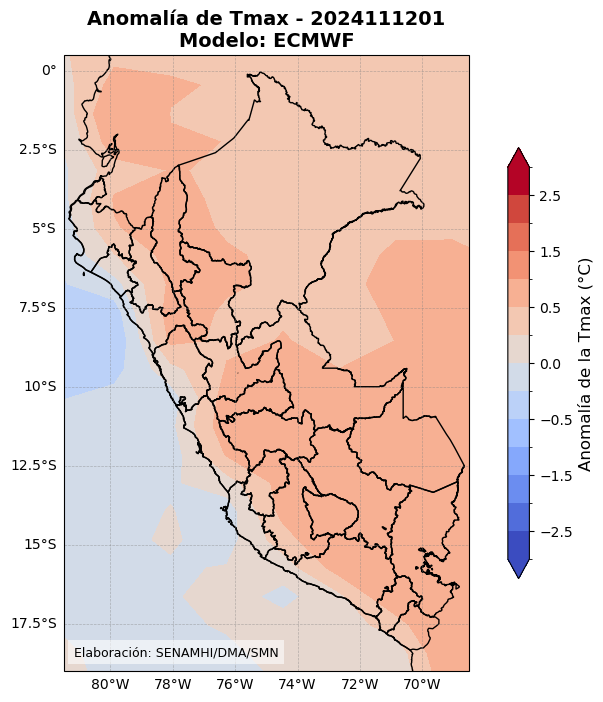

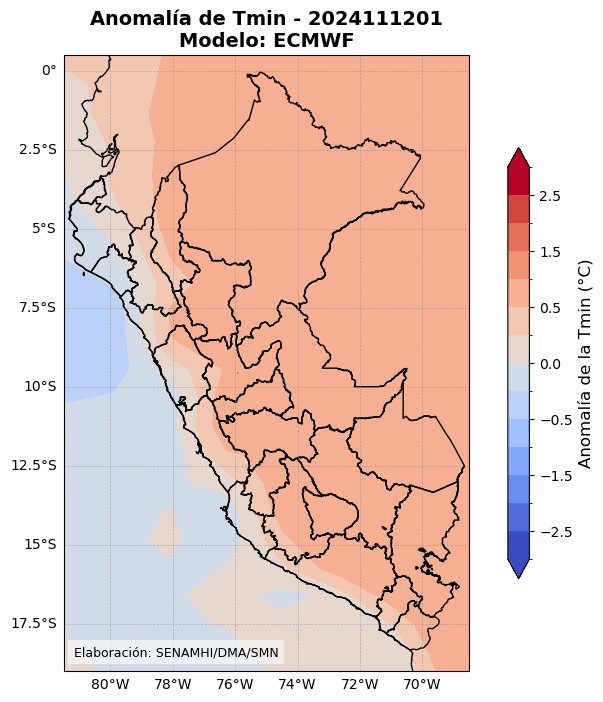

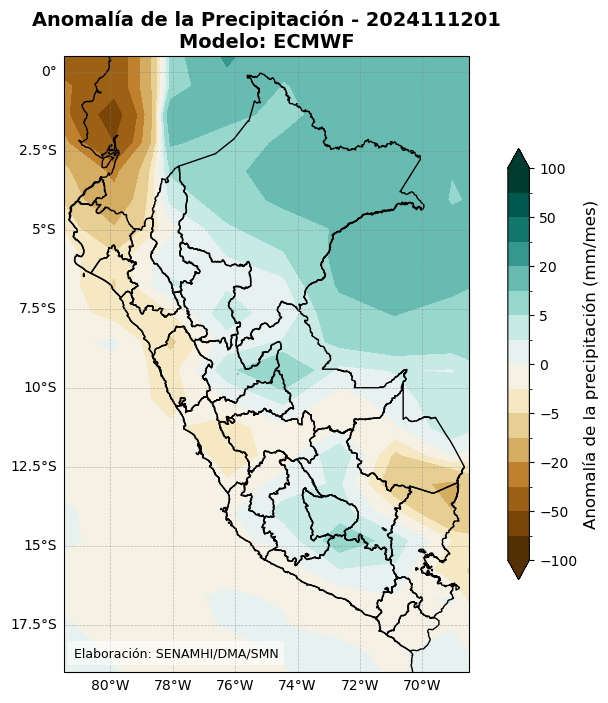

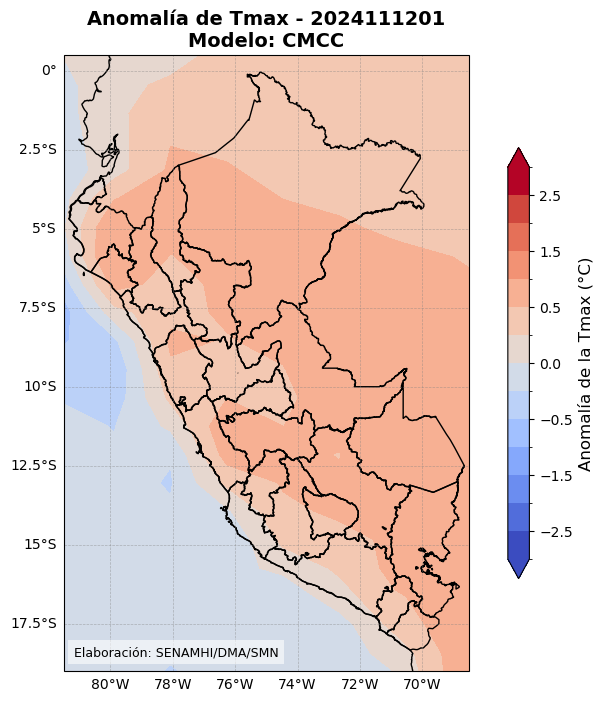

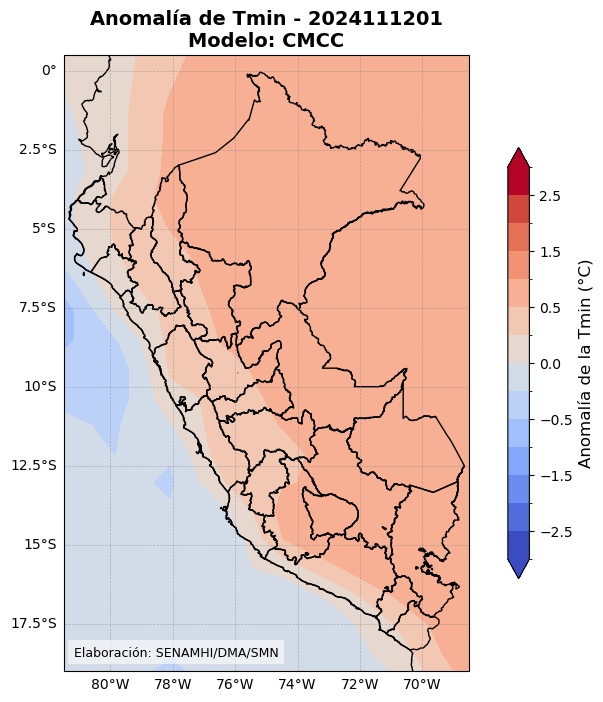

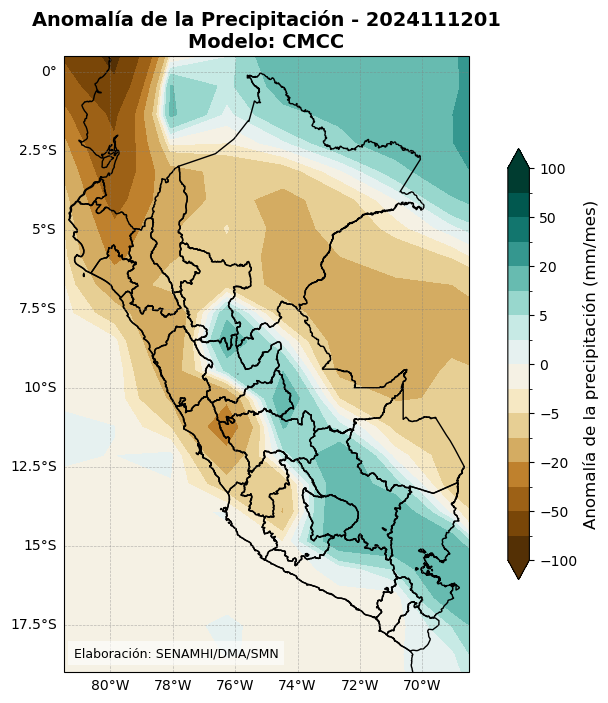

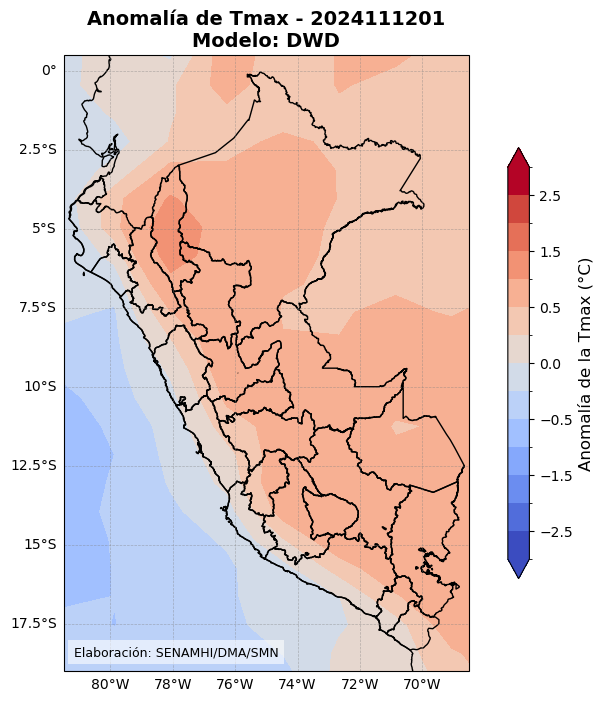

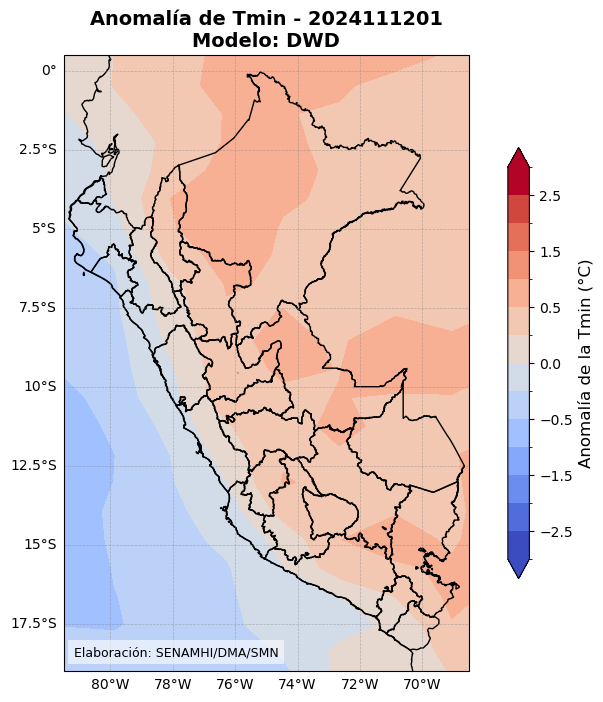

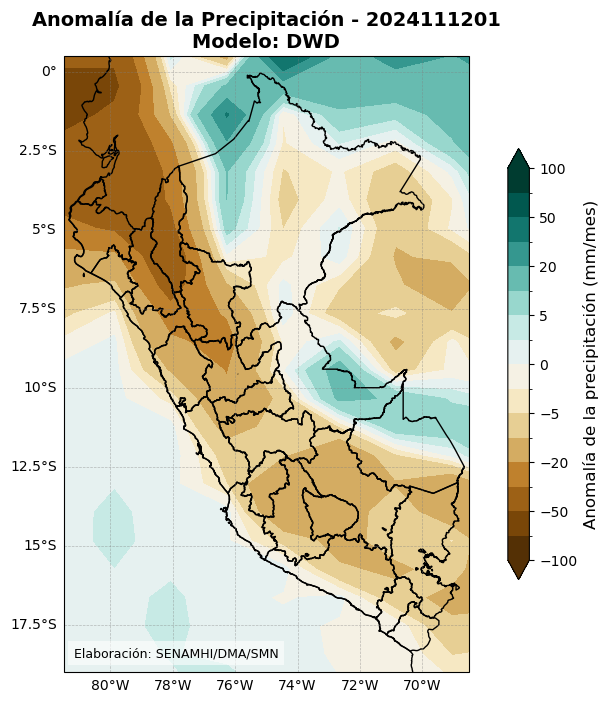

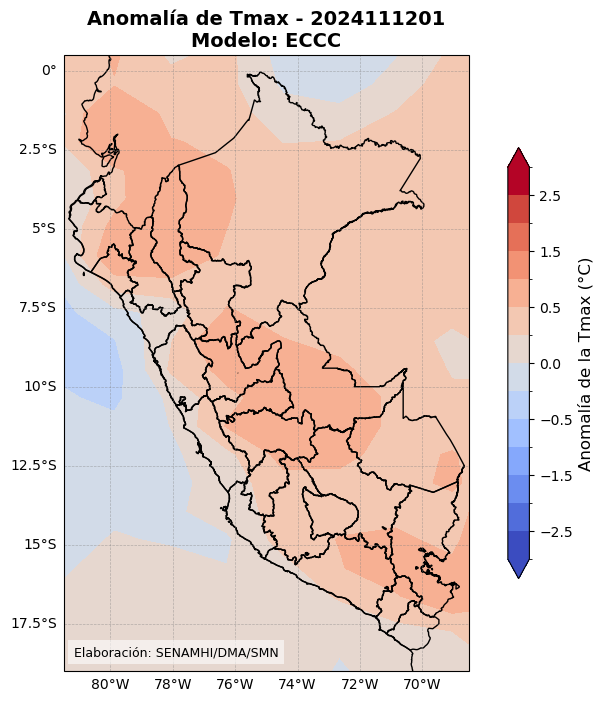

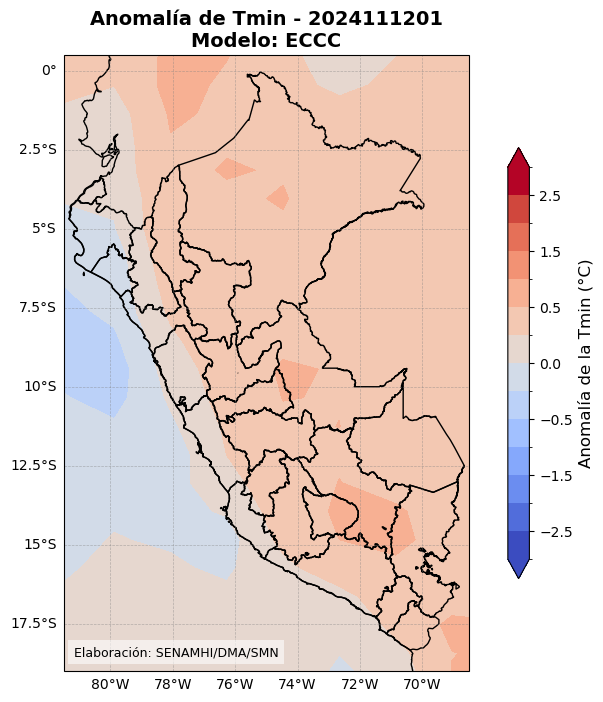

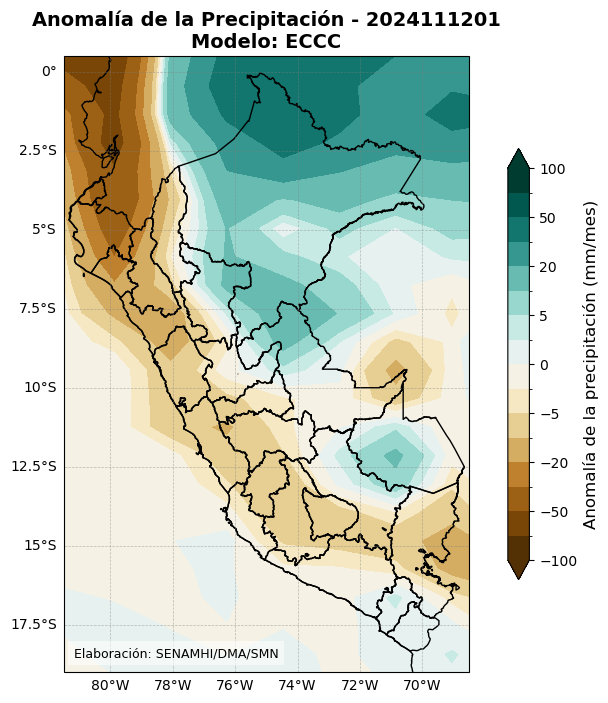

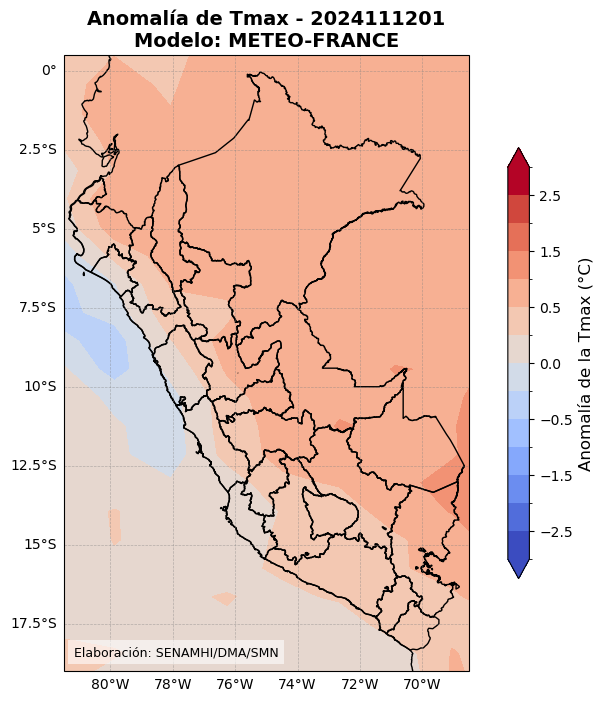

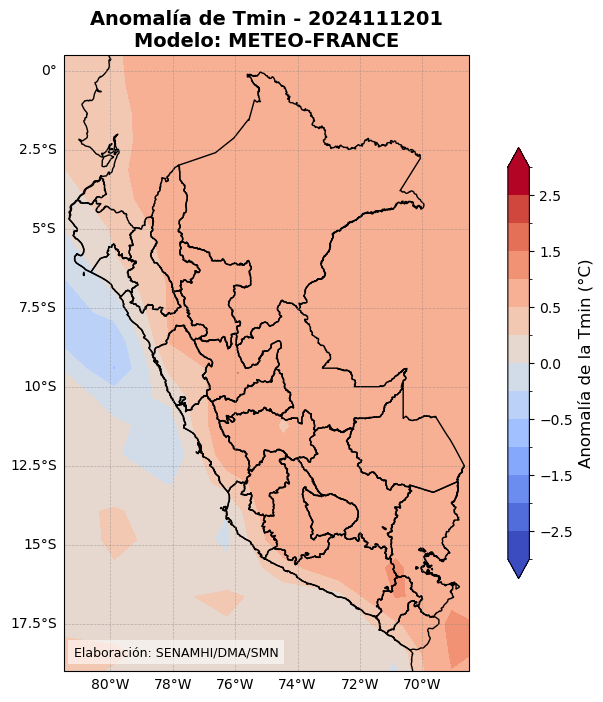

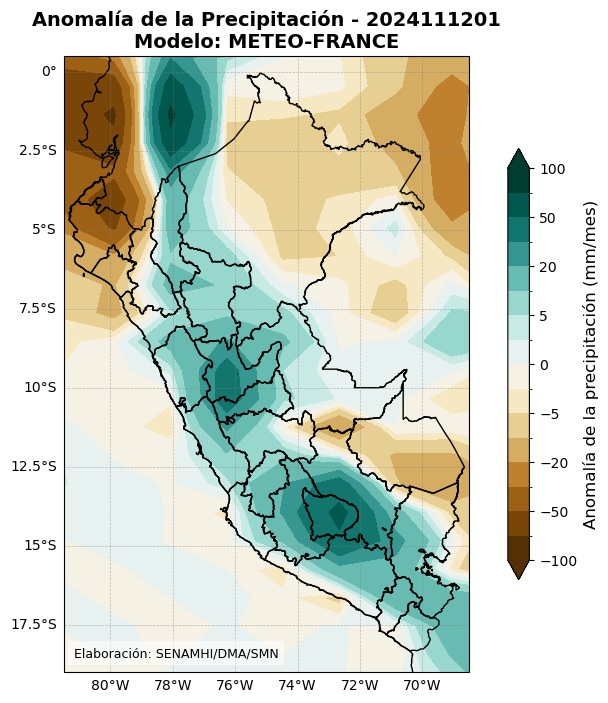

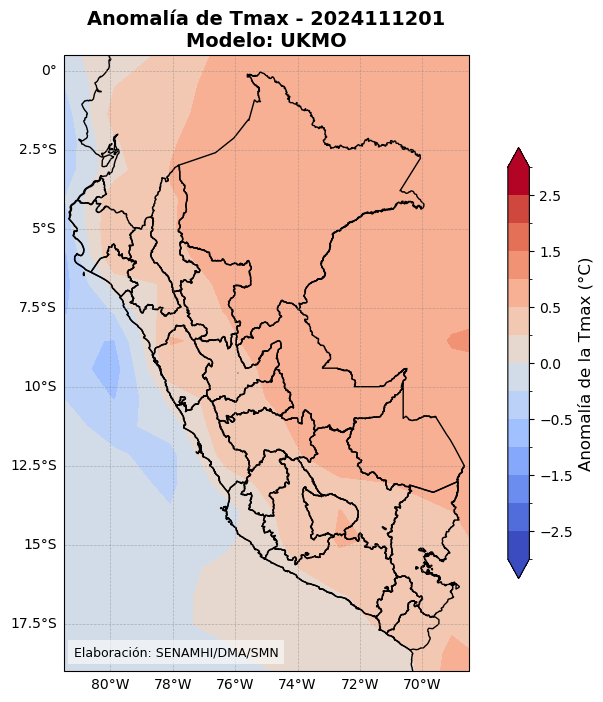

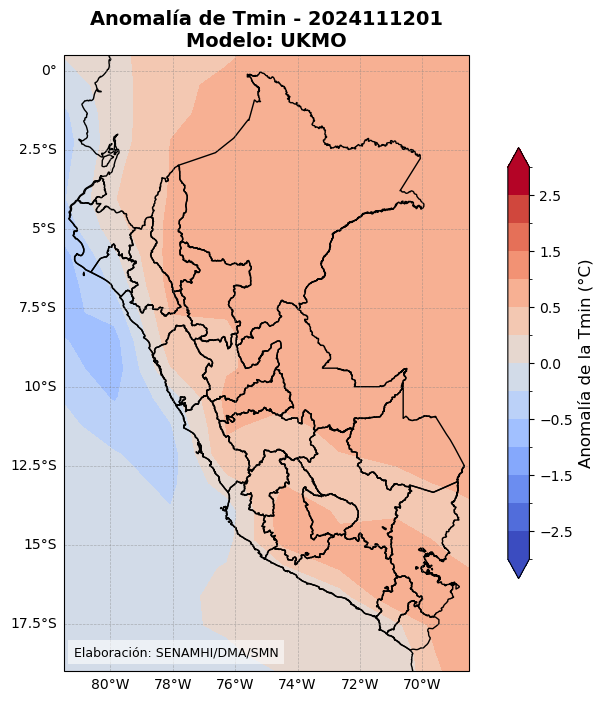

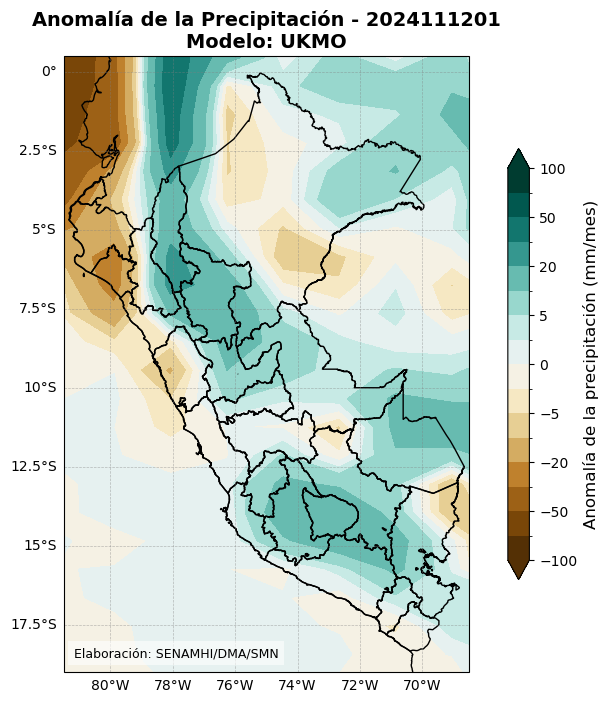

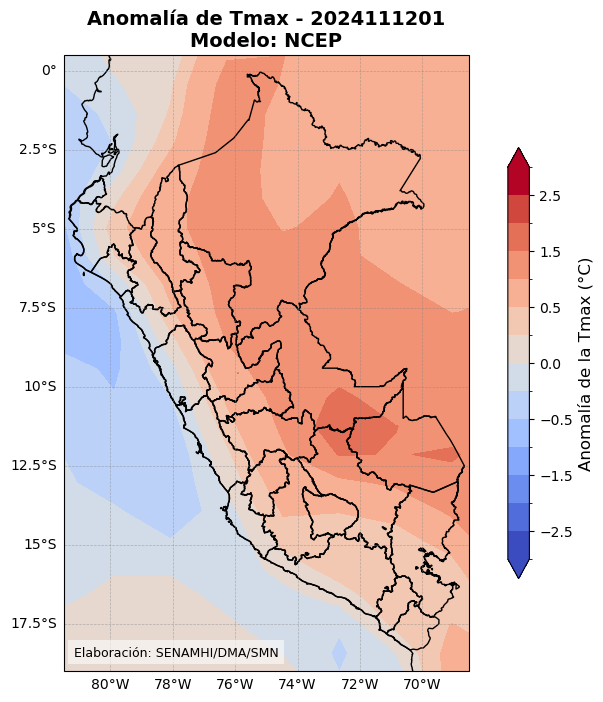

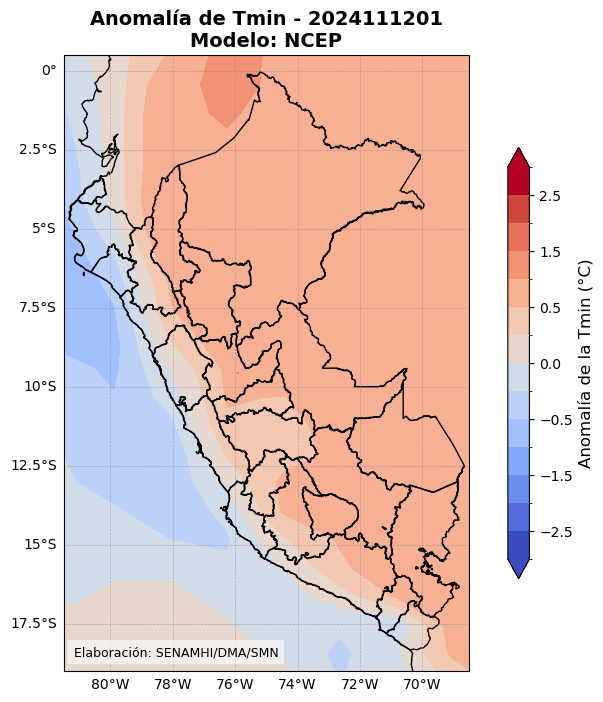

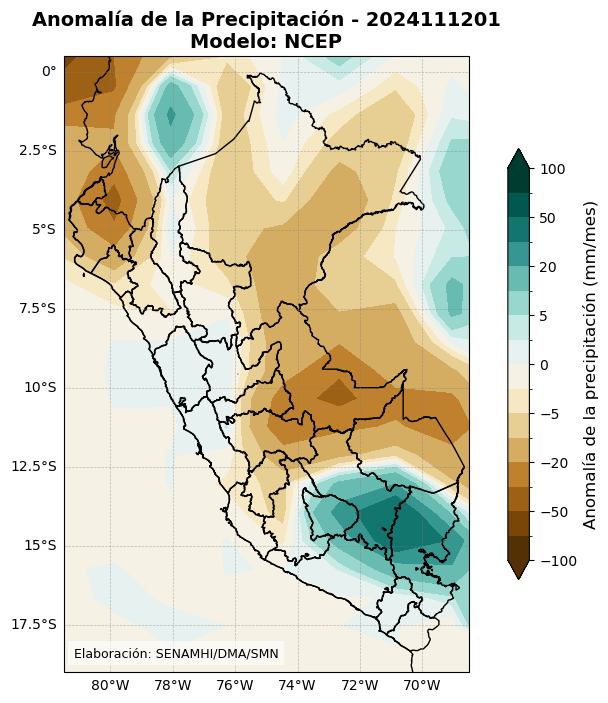

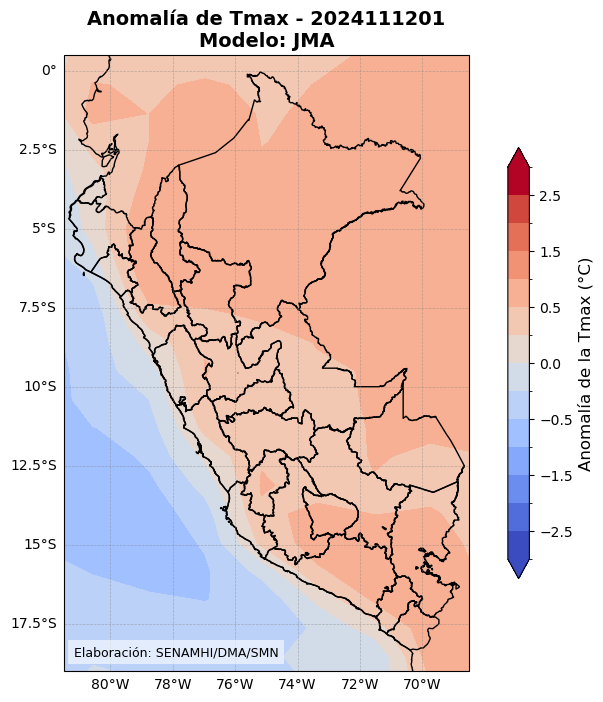

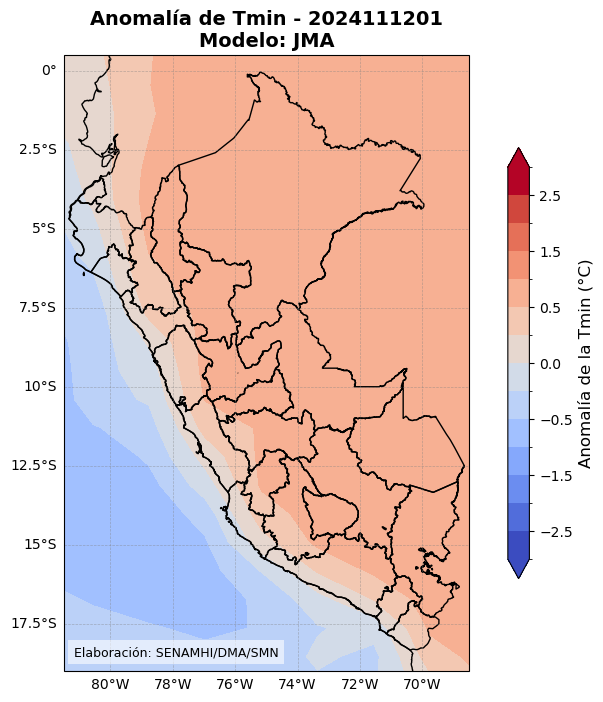

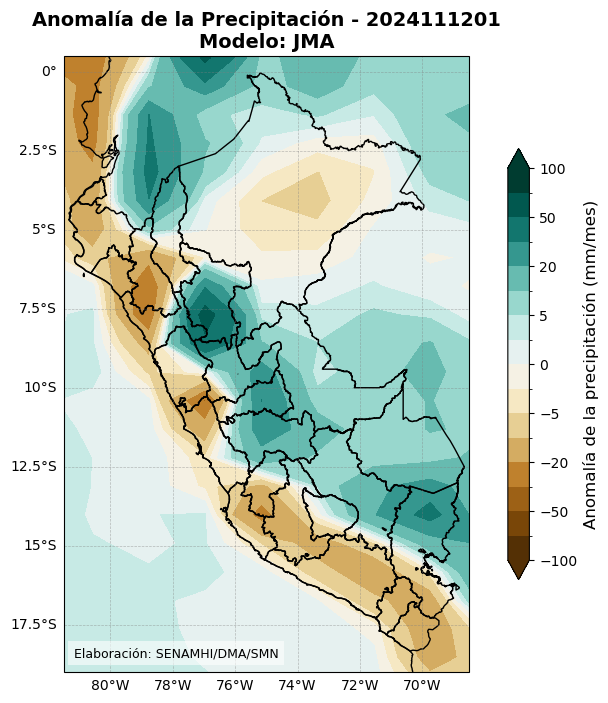

In [ ]:
import os
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import geopandas as gpd
from matplotlib.colors import BoundaryNorm
import pandas as pd
from scipy.interpolate import griddata
import matplotlib.ticker as mticker

# Fecha inicial en formato 'YYYYMM', se define una sola vez
FECHA_INICIAL = '202410'

# Definir la función para interpolar los datos
def cubic_interpolation(variable, lon, lat, new_lon, new_lat):
    lon2d, lat2d = np.meshgrid(lon, lat)
    points = np.array([lon2d.flatten(), lat2d.flatten()]).T
    values = variable.values.flatten()

    new_lon2d, new_lat2d = np.meshgrid(new_lon, new_lat)
    new_points = np.array([new_lon2d.flatten(), new_lat2d.flatten()]).T

    interpolated_values = griddata(points, values, new_points, method='cubic')
    return interpolated_values.reshape(new_lon2d.shape)

# Definir la función para crear y mostrar los gráficos
def plot_variable(variable, variable_name, cmap, bounds, norm, title_prefix, output_dir, filename_suffix, colorbar_label, modelo, ref_time):
    # Promedio trimestral de los meses 2, 3 y 4
    if 'forecastMonth' in variable.coords:
        variable_avg = variable.sel(forecastMonth=[2, 3, 4]).mean(dim='forecastMonth')
    else:
        return

    # Obtener la fecha de inicio y los meses correspondientes
    try:
        if isinstance(ref_time, (int, float)) or pd.isnull(ref_time):
            raise ValueError("Invalid ref_time format")
        ref_time_dt = pd.to_datetime(ref_time)
    except (ValueError, TypeError):
        ref_time_dt = pd.Timestamp('1970-01-01')  # Fecha por defecto si falla la conversión

    date_str = f"{ref_time_dt.year}{(ref_time_dt + pd.DateOffset(months=1)).strftime('%m')}" \
               f"{(ref_time_dt + pd.DateOffset(months=2)).strftime('%m')}" \
               f"{(ref_time_dt + pd.DateOffset(months=3)).strftime('%m')}"

    lon = variable_avg['longitude'].values
    lat = variable_avg['latitude'].values

    new_lon = np.linspace(lon.min(), lon.max(), 200)
    new_lat = np.linspace(lat.min(), lat.max(), 200)

    interpolated_values = cubic_interpolation(variable_avg, lon, lat, new_lon, new_lat)

    fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})

    if not np.isnan(interpolated_values).all():
        plot = ax.contourf(new_lon, new_lat, interpolated_values, levels=bounds, cmap=cmap, norm=norm, extend='both', transform=ccrs.PlateCarree())

        shapefile.plot(ax=ax, facecolor='none', edgecolor='black')

        ax.set_title(f'{title_prefix} - {date_str}\nModelo: {modelo.upper()}', fontsize=14, fontweight='bold')

        ax.set_extent(extent)

        gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
        gl.xlocator = mticker.MultipleLocator(2)
        gl.ylocator = mticker.MultipleLocator(2.5)
        gl.top_labels = False
        gl.right_labels = False

        ax.coastlines()
        cbar = fig.colorbar(plot, ax=ax, orientation='vertical', shrink=0.7)
        cbar.set_label(colorbar_label, fontsize=12)

        ax.text(0.53, 0.02, 'Elaboración: SENAMHI/DMA/SMN',
                horizontalalignment='right', verticalalignment='bottom',
                transform=ax.transAxes, fontsize=9, color='black',
                bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))

        filename = f'pre_{modelo}_{date_str}_{filename_suffix}_per.png'
        plt.savefig(os.path.join(output_dir, filename), dpi=300, bbox_inches='tight')
        plt.show()

    else:
        ax.set_title(f'Datos no disponibles - {date_str}')
        ax.set_extent(extent)
        plt.show()

    plt.close()

# Lista de modelos a procesar
modelos = ['ecmwf', 'cmcc', 'dwd', 'eccc', 'meteo-france', 'ukmo', 'ncep', 'jma']
#modelos = ['ECMWF', 'CMCC', 'DWD', 'ECCC', 'METEO-FRANCE', 'UKMO', 'NCEP', 'JMA']

# Parámetros para las variables con los intervalos invertidos
variables_info = {
    'mx2t24a': {
        'cmap': 'coolwarm',
        'bounds': np.array([-3, -2.5, -2, -1.5, -1, -0.5, -0.25, 0, 0.25, 0.5, 1, 1.5, 2, 2.5, 3]),
        'title_prefix': 'Anomalía de Tmax',
        'filename_suffix': 'anomTempMax',
        'colorbar_label': 'Anomalía de la Tmax (°C)'
    },
    'mn2t24a': {
        'cmap': 'coolwarm',
        'bounds': np.array([-3, -2.5, -2, -1.5, -1, -0.5, -0.25, 0, 0.25, 0.5, 1, 1.5, 2, 2.5, 3]),
        'title_prefix': 'Anomalía de Tmin',
        'filename_suffix': 'anomTempMin',
        'colorbar_label': 'Anomalía de la Tmin (°C)'
    },
    'tpara': {
        'cmap': 'BrBG',
        'bounds': np.array([-100, -80, -50, -30, -20, -10, -5, -2.5, 0, 2.5, 5, 10, 20, 30, 50, 80, 100]),
        'title_prefix': 'Anomalía de la Precipitación',
        'filename_suffix': 'anomPrec',
        'colorbar_label': 'Anomalía de la precipitación (mm/mes)'
    }
}

# Cargar el shapefile
shapefile = gpd.read_file('/scratch/shape/SHAPES/DEPARTAMENTOS.shp')
extent = [-81.5, -68.5, -19, 0.5]

# Obtener la fecha de referencia del modelo ECMWF
ds_ecmwf = xr.open_dataset(f'/scratch/DMA/SMN/CLIMA/C3S/{FECHA_INICIAL}/flx.anom.ecmwf.nc')
ref_time_ecmwf = ds_ecmwf['forecast_reference_time'].values[0] if 'forecast_reference_time' in ds_ecmwf else pd.Timestamp('1970-01-01')

# Procesar cada modelo
for modelo in modelos:
    ds = xr.open_dataset(f'/scratch/DMA/SMN/CLIMA/C3S/{FECHA_INICIAL}/flx.anom.{modelo}.nc')

    if 'tpara' in ds:
        segundos_por_mes = 30 * 24 * 3600
        ds['tpara'] = ds['tpara'] * 1000 * segundos_por_mes

    # Para NCEP y JMA, usar la fecha de ECMWF
    if modelo in ['ncep', 'jma']:
        ref_time = ref_time_ecmwf
    else:
        ref_time = ds['forecast_reference_time'].values[0] if 'forecast_reference_time' in ds else pd.Timestamp('1970-01-01')

    fecha_inicio = pd.to_datetime(ref_time).strftime('%Y%m')
    output_dir = '/scratch/DMA/SMN/CLIMA/web_figuras/prediccion/trimestral'
    os.makedirs(output_dir, exist_ok=True)

    for var, info in variables_info.items():
        if var in ds:
            variable = ds[var]
            norm = BoundaryNorm(boundaries=info['bounds'], ncolors=256)
            plot_variable(variable, var, info['cmap'], info['bounds'], norm, info['title_prefix'], output_dir, info['filename_suffix'], info['colorbar_label'], modelo, ref_time)


Archivo descargado exitosamente: departamentos.shp
Archivo descargado exitosamente: departamentos.dbf
Archivo descargado exitosamente: departamentos.shx
Archivo descargado exitosamente: flx.anom.ecmwf.nc
Archivo descargado exitosamente: flx.anom.ecmwf.nc


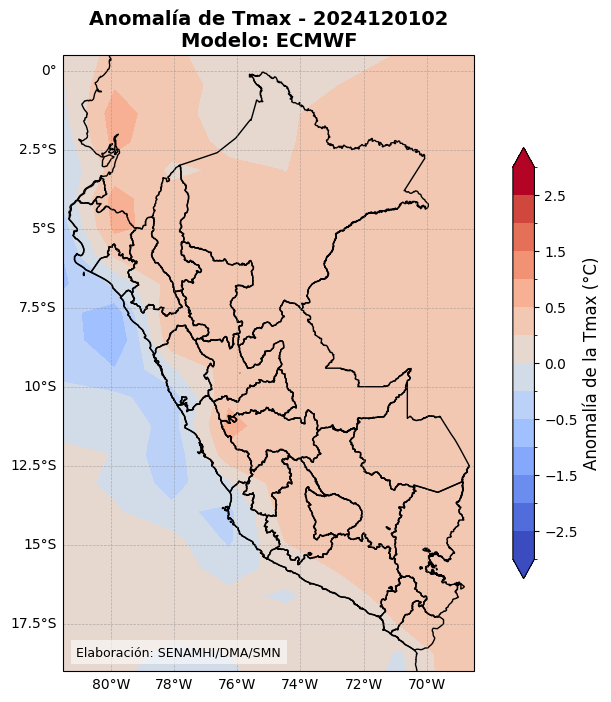

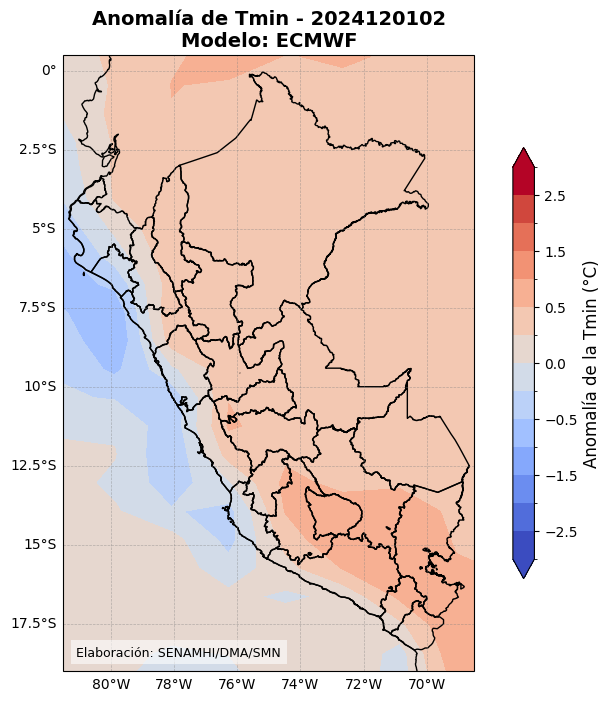

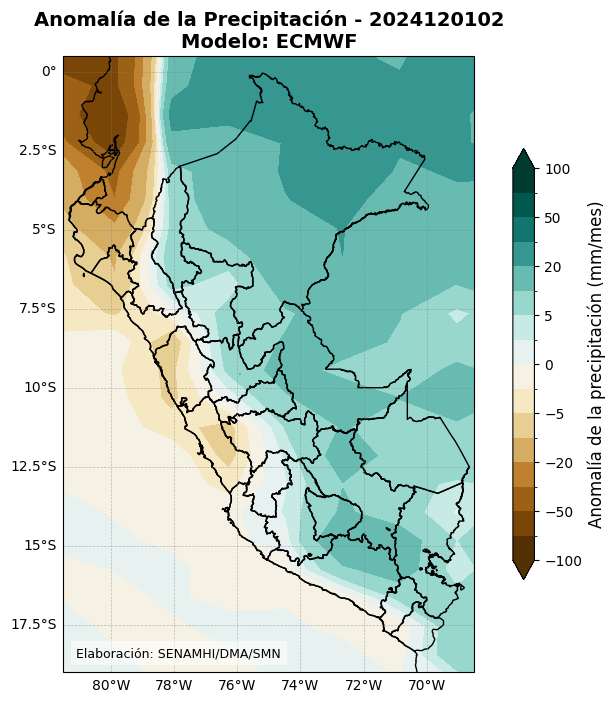

In [8]:
# Instalar librerías necesarias
!pip install xarray cartopy matplotlib pandas scipy geopandas

import os
import requests
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
from matplotlib.colors import BoundaryNorm
import pandas as pd
from scipy.interpolate import griddata
import matplotlib.ticker as mticker
import geopandas as gpd

# Función para descargar archivos desde una URL
def download_file(url, local_path):
    try:
        response = requests.get(url, stream=True)
        if response.status_code == 200:
            with open(local_path, "wb") as f:
                f.write(response.content)
            print(f"Archivo descargado exitosamente: {local_path}")
        else:
            print(f"Error al descargar el archivo: {response.status_code}")
    except Exception as e:
        print(f"Error durante la descarga: {e}")

# Descargar archivos de datos y shapefiles
shapefiles = {
    "departamentos.shp": "https://raw.githubusercontent.com/Jorgellamocca/GitC3Swrf/main/shape/DEPARTAMENTOS.shp",
    "departamentos.dbf": "https://raw.githubusercontent.com/Jorgellamocca/GitC3Swrf/main/shape/DEPARTAMENTOS.dbf",
    "departamentos.shx": "https://raw.githubusercontent.com/Jorgellamocca/GitC3Swrf/main/shape/DEPARTAMENTOS.shx",
}

for name, url in shapefiles.items():
    download_file(url, name)

# Configurar el directorio de salida
output_dir = '/content/graphics'
os.makedirs(output_dir, exist_ok=True)

# Descargar archivo NetCDF desde GitHub
data_url = "https://raw.githubusercontent.com/Jorgellamocca/GitC3Swrf/main/data/flx.anom.ecmwf.nc"
local_data_file = "flx.anom.ecmwf.nc"
download_file(data_url, local_data_file)

# Fecha inicial en formato 'YYYYMM'
FECHA_INICIAL = '202411'

# Definir la función para interpolar los datos
def cubic_interpolation(variable, lon, lat, new_lon, new_lat):
    lon2d, lat2d = np.meshgrid(lon, lat)
    points = np.array([lon2d.flatten(), lat2d.flatten()]).T
    values = variable.values.flatten()

    new_lon2d, new_lat2d = np.meshgrid(new_lon, new_lat)
    new_points = np.array([new_lon2d.flatten(), new_lat2d.flatten()]).T

    interpolated_values = griddata(points, values, new_points, method='cubic')
    return interpolated_values.reshape(new_lon2d.shape)

# Definir la función para crear y mostrar los gráficos
def plot_variable(variable, variable_name, cmap, bounds, norm, title_prefix, output_dir, filename_suffix, colorbar_label, modelo, ref_time):
    # Promedio trimestral de los meses 2, 3 y 4
    if 'forecastMonth' in variable.coords:
        variable_avg = variable.sel(forecastMonth=[2, 3, 4]).mean(dim='forecastMonth')
    else:
        return

    # Obtener la fecha de inicio y los meses correspondientes
    try:
        if isinstance(ref_time, (int, float)) or pd.isnull(ref_time):
            raise ValueError("Invalid ref_time format")
        ref_time_dt = pd.to_datetime(ref_time)
    except (ValueError, TypeError):
        ref_time_dt = pd.Timestamp('1970-01-01')  # Fecha por defecto si falla la conversión

    date_str = f"{ref_time_dt.year}{(ref_time_dt + pd.DateOffset(months=1)).strftime('%m')}" \
               f"{(ref_time_dt + pd.DateOffset(months=2)).strftime('%m')}" \
               f"{(ref_time_dt + pd.DateOffset(months=3)).strftime('%m')}"

    lon = variable_avg['longitude'].values
    lat = variable_avg['latitude'].values

    new_lon = np.linspace(lon.min(), lon.max(), 200)
    new_lat = np.linspace(lat.min(), lat.max(), 200)

    interpolated_values = cubic_interpolation(variable_avg, lon, lat, new_lon, new_lat)

    fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})

    if not np.isnan(interpolated_values).all():
        plot = ax.contourf(new_lon, new_lat, interpolated_values, levels=bounds, cmap=cmap, norm=norm, extend='both', transform=ccrs.PlateCarree())

        shapefile.plot(ax=ax, facecolor='none', edgecolor='black')

        ax.set_title(f'{title_prefix} - {date_str}\nModelo: {modelo.upper()}', fontsize=14, fontweight='bold')

        ax.set_extent(extent)

        gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
        gl.xlocator = mticker.MultipleLocator(2)
        gl.ylocator = mticker.MultipleLocator(2.5)
        gl.top_labels = False
        gl.right_labels = False

        ax.coastlines()
        cbar = fig.colorbar(plot, ax=ax, orientation='vertical', shrink=0.7)
        cbar.set_label(colorbar_label, fontsize=12)

        ax.text(0.53, 0.02, 'Elaboración: SENAMHI/DMA/SMN',
                horizontalalignment='right', verticalalignment='bottom',
                transform=ax.transAxes, fontsize=9, color='black',
                bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))

        filename = f'pre_{modelo}_{date_str}_{filename_suffix}_per.png'
        plt.savefig(os.path.join(output_dir, filename), dpi=300, bbox_inches='tight')
        plt.show()

    else:
        ax.set_title(f'Datos no disponibles - {date_str}')
        ax.set_extent(extent)
        plt.show()

    plt.close()

# Lista de modelos a procesar
#modelos = ['ecmwf', 'cmcc', 'dwd', 'eccc', 'meteo-france', 'ukmo', 'ncep', 'jma']
modelos = ['ecmwf']
# Parámetros para las variables con los intervalos invertidos
variables_info = {
    'mx2t24a': {
        'cmap': 'coolwarm',
        'bounds': np.array([-3, -2.5, -2, -1.5, -1, -0.5, -0.25, 0, 0.25, 0.5, 1, 1.5, 2, 2.5, 3]),
        'title_prefix': 'Anomalía de Tmax',
        'filename_suffix': 'anomTempMax',
        'colorbar_label': 'Anomalía de la Tmax (°C)'
    },
    'mn2t24a': {
        'cmap': 'coolwarm',
        'bounds': np.array([-3, -2.5, -2, -1.5, -1, -0.5, -0.25, 0, 0.25, 0.5, 1, 1.5, 2, 2.5, 3]),
        'title_prefix': 'Anomalía de Tmin',
        'filename_suffix': 'anomTempMin',
        'colorbar_label': 'Anomalía de la Tmin (°C)'
    },
    'tpara': {
        'cmap': 'BrBG',
        'bounds': np.array([-100, -80, -50, -30, -20, -10, -5, -2.5, 0, 2.5, 5, 10, 20, 30, 50, 80, 100]),
        'title_prefix': 'Anomalía de la Precipitación',
        'filename_suffix': 'anomPrec',
        'colorbar_label': 'Anomalía de la precipitación (mm/mes)'
    }
}

# Cargar el shapefile
shapefile = gpd.read_file('departamentos.shp')
extent = [-81.5, -68.5, -19, 0.5]

# Obtener la fecha de referencia del modelo ECMWF
ds_ecmwf = xr.open_dataset(local_data_file)
ref_time_ecmwf = ds_ecmwf['forecast_reference_time'].values[0] if 'forecast_reference_time' in ds_ecmwf else pd.Timestamp('1970-01-01')

# Procesar cada modelo
for modelo in modelos:
    data_url = f"https://raw.githubusercontent.com/Jorgellamocca/GitC3Swrf/main/data/flx.anom.{modelo}.nc"
    local_data_file = f"flx.anom.{modelo}.nc"
    download_file(data_url, local_data_file)

    ds = xr.open_dataset(local_data_file)

    if 'tpara' in ds:
        segundos_por_mes = 30 * 24 * 3600
        ds['tpara'] = ds['tpara'] * 1000 * segundos_por_mes

    # Para NCEP y JMA, usar la fecha de ECMWF
    if modelo in ['ncep', 'jma']:
        ref_time = ref_time_ecmwf
    else:
        ref_time = ds['forecast_reference_time'].values[0] if 'forecast_reference_time' in ds else pd.Timestamp('1970-01-01')

    fecha_inicio = pd.to_datetime(ref_time).strftime('%Y%m')

    for var, info in variables_info.items():
        if var in ds:
            variable = ds[var]
            norm = BoundaryNorm(boundaries=info['bounds'], ncolors=256)
            plot_variable(variable, var, info['cmap'], info['bounds'], norm, info['title_prefix'], output_dir, info['filename_suffix'], info['colorbar_label'], modelo, ref_time)
